# Analyzing A/B test results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

**In this project we will be analysing A/B test results in order to decide a e-commerce website to help to decide wheather they should implement the new page or keep the existing page or perhapswun the experiment longer to make their decision**



<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [63]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [64]:
df = pd.read_csv("ab_data.csv")
df.head()


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [65]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [66]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

d. The proportion of users converted.

In [67]:
df["converted"].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [69]:
x= len(df.query("group=='treatment' & landing_page !='new_page'"))
y = len(df.query("landing_page == 'new_page' & group != 'treatment'"))
print(x,y)
z= x+y
print("The total number of times where 'new_page' and 'treatment' doesnt match is : ", z)

1965 1928
The total number of times where 'new_page' and 'treatment' doesnt match is :  3893


f. Do any of the rows have missing values?

In [70]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [72]:
df.drop(df.query("group=='treatment' & landing_page !='new_page'").index, inplace = True)
df.drop(df.query("landing_page == 'new_page' & group != 'treatment'").index, inplace=True)

df2 = df.copy()


In [73]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]


0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [74]:
df2.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

b. There is one **user_id** repeated in **df2**.  What is it?

In [75]:

df2[df2.duplicated(['user_id'], keep=False)]['user_id'].unique()

array([773192])

c. What is the row information for the repeat **user_id**? 

In [76]:

df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [77]:

df2.drop_duplicates(['user_id'],inplace=True)

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [78]:
df2["converted"].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [79]:
df2.groupby("group")["converted"].mean()

group
control      0.120386
treatment    0.118808
Name: converted, dtype: float64

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [80]:
df2.groupby("group")["converted"].mean()

group
control      0.120386
treatment    0.118808
Name: converted, dtype: float64

d. What is the probability that an individual received the new page?

In [81]:
x = len(df2.query("landing_page=='new_page'"))
y = len(df2["user_id"])

print("Probability that an individual received the new page is : ", x/y)

Probability that an individual received the new page is :  0.5000619442226688


e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

`It is not possible to conclude our analysis based on result provided by part a and b only beacuse the given result are not strong evidence to conclude that the new treatment page leads to more conversions. For example: the probability that an individual received the new page is almost 50% which  doesn't prove that all new treatment page will be more converted. And even timestamp might play an important role to make a decision by e-commerse website `

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

H0 = **$p_{new}$** <= **$p_{old}$** <br>
H1 = **$p_{new}$** > **$p_{old}$**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [83]:
# As both have "true" success rates equal to the converted success rate regardless of page - that is  𝑝𝑛𝑒𝑤  and  𝑝𝑜𝑙𝑑  are equal.
p_new= df2["converted"].mean()
p_new


0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [84]:
# And both Pnew and Pold has same converted rate
p_old= df2["converted"].mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [86]:
n_new = len(df2.query("group=='treatment'"))
n_new


145310

d. What is $n_{old}$, the number of individuals in the control group?

In [87]:
n_old=len(df2.query("group=='control'"))
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [88]:
new_page_converted = np.random.choice([0,1],n_new, p = (p_new,1-p_new))
new_page_converted

array([1, 1, 1, ..., 1, 1, 1])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [90]:
old_page_converted = np.random.choice([0,1],n_old, p = (p_old,1-p_old))
old_page_converted

array([1, 1, 1, ..., 1, 1, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [91]:
dif= new_page_converted.mean()- old_page_converted.mean()
dif

-0.00098222799064484612

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [92]:
p_diffs=[]

for i in range(10000): 
    new_page_converted = np.random.choice([0,1],n_new, p = (p_new,1-p_new) )
    old_page_converted = np.random.choice([0,1],n_old, p = (p_old,1-p_old))
    obs_diff = new_page_converted.mean() - old_page_converted.mean()
    p_diffs.append(obs_diff)
    
p_diffs = np.array(p_diffs)


i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

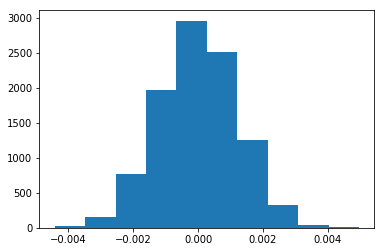

In [94]:
plt.hist(p_diffs);

In [95]:
obs_diff = df[df['landing_page'] == 'new_page']['converted'].mean() -  df[df['landing_page'] == 'old_page']['converted'].mean()
obs_diff


-0.0015790565976871451

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

0.90539999999999998

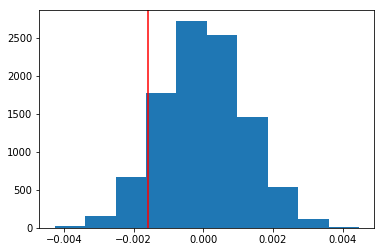

In [96]:
null_vals = np.random.normal(0,p_diffs.std(),p_diffs.size)
plt.hist(null_vals)
plt.axvline(x=obs_diff,color="red")


(null_vals > obs_diff).mean()

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Here in part J, we calculate the null values and plotted as histrogram and the find the p-value by finding the mean value where null values were grater than the observed value . If P-value < 0.05 then we reject the null hypothesis and accept that alternative hypothesis wlse viseversa . But the value was greater than the type error i.e P_new  is less than or equal to  Pnew or Old page is better than the new_page**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [98]:
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

convert_old = sum(df2.query("landing_page == 'old_page'")["converted"])
convert_new = sum(df2.query("landing_page == 'new_page'")["converted"])
n_old = len(df2.query("landing_page == 'old_page'"))
n_new = len(df2.query("landing_page == 'new_page'"))
convert_old,convert_new,n_old,n_new

(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [99]:
z_score, p_value = sm.stats.proportions_ztest(np.array([convert_new,convert_old]),np.array([n_new,n_old]), alternative = 'larger')
print('z_score :: ',z_score)
print('p_value :: ',p_value)


z_score ::  -1.31092419842
p_value ::  0.905058312759


In [100]:
from scipy.stats import norm
#significant of z-score
print(norm.cdf(z_score))

#fro our single-sides test , assumed at 95% confidence level , we calculate:
print(norm.ppf(1-0.05))

0.094941687241
1.64485362695


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**z-score is a measure of how many standard deviations below or above the population mean a raw score is. We find that the z-score of 1.31092419842 is less than the critical value 1.64485362695 which means we cant reject the null hypothesis . We find that old page conversions are slightly bbetter than new page conversions. Eventhough the valies are different from findings in parts j. and k but it suffest there is no significant difference between ild page and new page conversions**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Since we are going to predict one of two possible outcomes from a categorical variable , we will be using Logistic Regression.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [101]:
import statsmodels.api as sm

df2["intercept"] = 1

df2[["control","ab_page"]] = pd.get_dummies(df["group"])
df2.head()
df2.drop("control", axis =1 , inplace =True)

df2.head(2)


,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [102]:
log_mod=sm.Logit(df2["converted"], df2[["intercept","ab_page"]])
results = log_mod.fit()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [103]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-06-01 13:00 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**Since the p-value of ab_page is 0.1897 which is greater than 0.05 (i.e p>0.05), therefore null hypothesis is true which is similar to  Part II but intest P_old is better than P_new , from this we can predict that there is no difference between new page and old page in terms of conversion**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**There might be other factors as well that affect individual convert, such as age_group or gender or interest_on  and even the time_stamp given on the data. Advantage of using others factors as weel is that we can find new trends using them . However the disadvantage is that : it could be more time consuiming when we want to predict in less time , more complexor even with new factors we may miss some other influencing factorswhich lead to unreliable and contradictory results compared to previous results. And also if new terms are dependable variable with the exisiting explanatory term, we need to add higher order term to help predict the result better**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [104]:
df3 = pd.read_csv("countries.csv")
df3.head(2)

,user_id,country
0,834778,UK
1,928468,US


In [105]:
df4 = df2.merge(df3, on="user_id", how='left')
df4.head(2)


,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US


In [106]:
df4["country"].unique()

array(['US', 'CA', 'UK'], dtype=object)

In [107]:
df4[["CA","UK","US"]] = pd.get_dummies(df4["country"])

df4.drop("CA", axis = 1, inplace = True)
df4.head(2)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,1


In [108]:
df4["intercept"] = 1

log_mol=sm.Logit(df4["converted"], df4[["intercept","UK","US"]])

results= log_mol.fit()
results.summary2()


Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-06-01 13:00 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0375    0.0260  -78.3639  0.0000  -2.0885  -1.9866
UK             0.0507    0.0284    1.7863  0.0740  -0.0049   0.1064
US             0.0408    0.0269    1.5178  0.1291  -0.0119   0.0935
==================================================================

"""

**Since both UK and US country has p-value > 0.05, which means that the countries are not statistically significant in predicting individual convert**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [112]:
log_mol=sm.Logit(df4["converted"], df4[["intercept","ab_page","UK","US"]])

results= log_mol.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-06-01 13:00 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
US             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
==================================================================

"""

**Same goes to this one as well as P-values of all variable is greater than 0.05 , therefore we will accept Null Hypothesis as there is no significant difference in vonversion rates and we can reject the alternative hypothesis based on the given summary information. However ther may be limitation due to incorrect data or missing colume or lack of other factor.**

In [113]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0